## Task 2 - Model Comparison and Analysis

In [222]:
import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import spearmanr

### Load embeddings from task 1

In [223]:
def load_npz(path):
    d = np.load(path, allow_pickle=True)
    emb = d["emb"].astype(np.float32)
    vocabs = list(d["vocabs"])
    meta = {k: d[k].item() if d[k].shape == () else d[k] for k in d.files if k not in ["emb","vocabs"]}
    return emb, vocabs, meta

paths = {
    "Skipgram": "./models/skipgram_softmax_w4.npz",
    "Skipgram (NEG)": "./models/skipgram_neg_w4.npz",
    "GloVe": "./models/glove_scratch_w4.npz"}

models_dict = {}
for name, p in paths.items():
    emb, vocabs, meta = load_npz(p)
    models_dict[name] = {"emb": emb, "vocabs": vocabs, "meta": meta}

### Prepare data + normalize

In [224]:
def build_w2i(vocabs):
    return {str(w).lower(): i for i, w in enumerate(vocabs)}

def normalize_rows(E):
    return E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

for name in models_dict:
    models_dict[name]["w2i"] = build_w2i(models_dict[name]["vocabs"])
    models_dict[name]["emb_norm"] = normalize_rows(models_dict[name]["emb"])

### Task 2.1 - Compare training loss & training time

In [225]:
df = pd.DataFrame([
    {"Model":"Skipgram",       "Window Size":4, "Training Loss":6.7764,   "Training time":899.727393},
    {"Model":"Skipgram (NEG)", "Window Size":4, "Training Loss":2.8022,   "Training time":132.299194},
    {"Model":"GloVe",          "Window Size":4, "Training Loss":111.1818, "Training time":295.148850}]) 
# Training Loss from final Loss in task 1
df

,Model,Window Size,Training Loss,Training time
0,Skipgram,4,6.7764,899.727393
1,Skipgram (NEG),4,2.8022,132.299194
2,GloVe,4,111.1818,295.148850


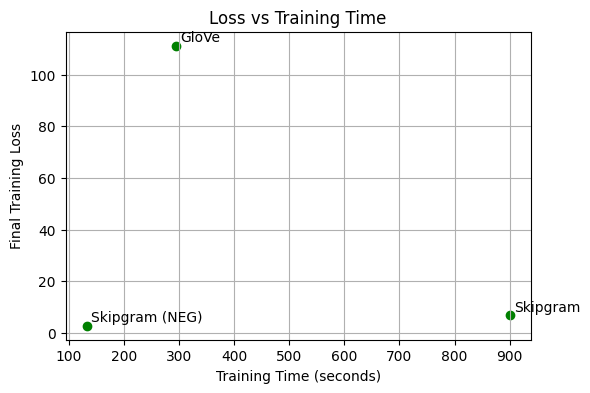

In [226]:
# create scatter plot for comparing

models = ["Skipgram", "Skipgram (NEG)", "GloVe"]

train_times = [
    df.loc[df["Model"]=="Skipgram","Training time"].values[0],
    df.loc[df["Model"]=="Skipgram (NEG)","Training time"].values[0],
    df.loc[df["Model"]=="GloVe","Training time"].values[0]]

losses = [
    df.loc[df["Model"]=="Skipgram","Training Loss"].values[0],
    df.loc[df["Model"]=="Skipgram (NEG)","Training Loss"].values[0],
    df.loc[df["Model"]=="GloVe","Training Loss"].values[0]]

plt.figure(figsize=(6,4))
plt.scatter(train_times, losses,color='g')

for i, m in enumerate(models):
    plt.annotate(m, (train_times[i], losses[i]),
                 textcoords="offset points", xytext=(3,3))

plt.xlabel("Training Time (seconds)")
plt.ylabel("Final Training Loss")
plt.title("Loss vs Training Time")
plt.grid()
plt.show()


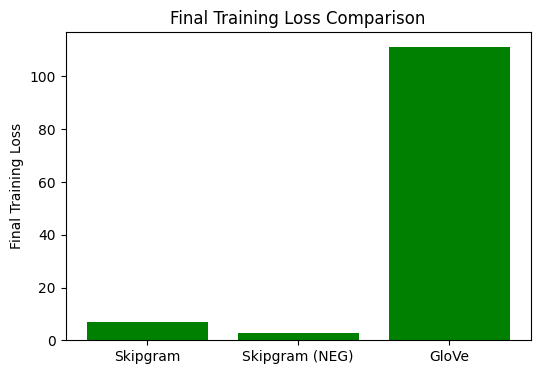

In [227]:
plt.figure(figsize=(6,4))
plt.bar(models, losses,color='g')
plt.ylabel("Final Training Loss")
plt.title("Final Training Loss Comparison")
plt.grid(False)
plt.show()


### Task 2.2 - Word Analogy Accuracy

In [228]:
# load word analogies dataset
import urllib.request

url = "https://www.fit.vut.cz/person/imikolov/public/rnnlm/word-test.v1.txt"
out_path = "./data/word-test.v1.txt"

os.makedirs(os.path.dirname(out_path), exist_ok=True)

urllib.request.urlretrieve(url, out_path)
print("Saved to:", out_path)

Saved to: ./data/word-test.v1.txt


In [229]:
# check num section and name
sections = []
with open("./data/word-test.v1.txt", "r", encoding="utf8") as f:
    for line in f:
        line = line.strip().lower()
        if line.startswith(":"):
            sections.append(line[1:].strip())

print("num sections:", len(sections))
print(sections) 

num sections: 14
['capital-common-countries', 'capital-world', 'currency', 'city-in-state', 'family', 'gram1-adjective-to-adverb', 'gram2-opposite', 'gram3-comparative', 'gram4-superlative', 'gram5-present-participle', 'gram6-nationality-adjective', 'gram7-past-tense', 'gram8-plural', 'gram9-plural-verbs']


In [230]:
# load semantic and syntactic
def load_word_test(path):
    semantic, syntactic = [], []
    current = None
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip().lower()
            if not line:
                continue
            if line.startswith(":"):
                current = line[1:].strip()
                continue
            parts = line.split()
            if len(parts) != 4 or current is None:
                continue
            a,b,c,d = parts
            if current.startswith("gram"):
                syntactic.append((a,b,c,d))
            else:
                semantic.append((a,b,c,d))
    return semantic, syntactic


semantic, syntactic = load_word_test("./data/word-test.v1.txt")
print("semantic:", len(semantic), "syntactic:", len(syntactic))

semantic: 8869 syntactic: 10675


In [231]:
#  calucalte between syntactic and semantic accuracy
def analogy_predict(a,b,c, emb_norm, w2i, vocabs):
    if a not in w2i or b not in w2i or c not in w2i:
        return None

    target = emb_norm[w2i[b]] - emb_norm[w2i[a]] + emb_norm[w2i[c]]
    target = target / (norm(target) + 1e-12)

    scores = emb_norm @ target
    scores[w2i[a]] = scores[w2i[b]] = scores[w2i[c]] = -1e9

    return vocabs[int(np.argmax(scores))]

def eval_analogy(pairs4, emb_norm, w2i, vocabs):
    total, correct = 0, 0
    for a,b,c,d in pairs4:
        pred = analogy_predict(a,b,c, emb_norm, w2i, vocabs)
        if pred is None:
            continue
        total += 1
        if pred == d:
            correct += 1
    return correct/total if total>0 else 0.0

In [232]:
acc = {}

for name, m in models_dict.items():
    acc_syn = eval_analogy(syntactic, m["emb_norm"], m["w2i"], m["vocabs"])
    acc_sem = eval_analogy(semantic,  m["emb_norm"], m["w2i"], m["vocabs"])
    acc[name] = (acc_syn, acc_sem)
    print(name, "syntactic:", acc_syn, "semantic:", acc_sem)

Skipgram syntactic: 0.0 semantic: 0.0
Skipgram (NEG) syntactic: 0.0 semantic: 0.004310344827586207
GloVe syntactic: 0.0 semantic: 0.0


In [233]:
import gensim.downloader as api
gensim_glove = api.load("glove-wiki-gigaword-100") 
print("loaded:", gensim_glove.vector_size, "vocab:", len(gensim_glove.key_to_index))

loaded: 100 vocab: 400000


In [234]:
def build_eval_vocab_from_pairs(pairs_list):
    words = set()
    for a,b,c,d in pairs_list:
        words.update([a,b,c,d])
    return sorted(words)

eval_vocab = build_eval_vocab_from_pairs(semantic + syntactic)
vocabs_g = [w for w in eval_vocab if w in gensim_glove.key_to_index]
w2i_g = {w:i for i,w in enumerate(vocabs_g)}
E = np.stack([gensim_glove[w] for w in vocabs_g]).astype(np.float32)
E_norm = normalize_rows(E)

acc_syn_g = eval_analogy(syntactic, E_norm, w2i_g, vocabs_g)
acc_sem_g = eval_analogy(semantic,  E_norm, w2i_g, vocabs_g)
print("GloVe (Gensim) syntactic:", acc_syn_g, "semantic:", acc_sem_g)

GloVe (Gensim) syntactic: 0.7285245901639344 semantic: 0.7003044311647311


In [235]:
df["Syntactic Accuracy"] = df["Model"].map(lambda m: acc[m][0] if m in acc else np.nan)
df["Semantic accuracy"]  = df["Model"].map(lambda m: acc[m][1] if m in acc else np.nan)
df = pd.concat([df, pd.DataFrame([{"Model": "Glove (Gensim)","Window Size": "-","Training Loss": "-","Training time": "-",
                                   "Syntactic Accuracy": acc_syn_g,"Semantic accuracy": acc_sem_g}])], ignore_index=True)
df

,Model,Window Size,Training Loss,Training time,Syntactic Accuracy,Semantic accuracy
0,Skipgram,4,6.7764,899.727393,0.000000,0.000000
1,Skipgram (NEG),4,2.8022,132.299194,0.000000,0.004310
2,GloVe,4,111.1818,295.14885,0.000000,0.000000
3,Glove (Gensim),-,-,-,0.728525,0.700304


### Task 2.3 - Similarity Correlation (Spearman)

In [236]:
def load_wordsim353(path):
    pairs, scores = [], []
    with open(path, encoding="utf8") as f:
        f.readline()
        for line in f:
            parts = line.strip().split(",")
            if len(parts) != 3:
                continue
            w1, w2, s = parts
            pairs.append((w1.lower(), w2.lower()))
            scores.append(float(s))
    return pairs, np.array(scores, dtype=np.float32)

pairs, y_true = load_wordsim353("./data/wordsim353crowd.csv")
print("Loaded pairs:", len(pairs))

Loaded pairs: 353


In [237]:
# dot product
def eval_spearman_wordsim(pairs, y_true, model_obj, use_norm=False):
    w2i = model_obj["w2i"]
    E = model_obj["emb_norm"] if use_norm else model_obj["emb"]

    y_pred, y_gold = [], []
    oov = 0

    for (w1, w2), s in zip(pairs, y_true):
        i1 = w2i.get(w1)
        i2 = w2i.get(w2)
        if i1 is None or i2 is None:
            oov += 1
            continue

        sim = float(E[i1] @ E[i2])  # dot product
        y_pred.append(sim)
        y_gold.append(float(s))

    rho, p = spearmanr(y_pred, y_gold)
    coverage = 1 - oov/len(pairs)

    return float(rho), float(p), float(coverage), len(y_pred)

In [238]:
scores = {}

for name in models_dict:
    rho, p, cov, used = eval_spearman_wordsim(pairs, y_true, models_dict[name], use_norm=False)
    scores[name] = {"spearman": rho,"p": p,"coverage": cov,"used": used}
    print(f"{name:14s} rho={rho:.4f}  p={p:.2e}  coverage={cov:.3f}  used={used}")

Skipgram       rho=0.0389  p=7.08e-01  coverage=0.269  used=95
Skipgram (NEG) rho=-0.0725  p=4.85e-01  coverage=0.269  used=95
GloVe          rho=-0.1055  p=3.09e-01  coverage=0.269  used=95


In [239]:
# build vocab only from words in dataset
ws_words = sorted({w for (a,b) in pairs for w in (a,b)})
ws_words_in = [w for w in ws_words if w in gensim_glove.key_to_index]

w2i_g = {w:i for i,w in enumerate(ws_words_in)}
E_g = np.stack([gensim_glove[w] for w in ws_words_in]).astype(np.float32) 

y_pred, y_gold = [], []
for (w1,w2), s in zip(pairs, y_true):
    if w1 in w2i_g and w2 in w2i_g:
        y_pred.append(float(E_g[w2i_g[w1]] @ E_g[w2i_g[w2]]))   
        y_gold.append(float(s))

rho_g, p_g = spearmanr(y_pred, y_gold)

scores["GloVe (gensim)"] = {
    "spearman": float(rho_g),
    "p": float(p_g),
    "coverage": len(y_pred)/len(pairs),
    "used": len(y_pred)}

In [240]:
def make_teacher_table(scores, row_name="Spearman"):
    cols = ["Skipgram", "NEG", "GloVe", "GloVe (gensim)", "Y_true"]
    row = [scores["Skipgram"]["spearman"],
            scores["Skipgram (NEG)"]["spearman"],
            scores["GloVe"]["spearman"],
            scores["GloVe (gensim)"]["spearman"],1.0]
    df = pd.DataFrame([row], columns=cols, index=[row_name])
    df.index.name = "Model"
    return df

df_2 = make_teacher_table(scores, row_name="Spearman")
df_2

,Skipgram,NEG,GloVe,GloVe (gensim),Y_true
Model,,,,,
Spearman,0.038932,-0.072454,-0.105534,0.407874,1.0
